In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from scipy.stats import f
from scipy.stats import mannwhitneyu
import statsmodels.api as sm
import os
import statannotations
from statannotations.Annotator import Annotator
import matplotlib.colors as mcolors

In [2]:
## Local conda env: py310
## Print versions
print("numpy", np.__version__)
print("pandas", pd.__version__)
print("seaborn", sns.__version__)
print("scipy", scipy.__version__)
print("statsmodels", sm.__version__)
print("statannotations", statannotations.__version__)

numpy 1.26.0
pandas 1.5.3
seaborn 0.11.2
scipy 1.11.3
statsmodels 0.14.0
statannotations 0.6.0


In [3]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['mathtext.rm'] = 'Arial'
plt.rcParams['font.family'] = ['Arial']
SMALL_SIZE = 5
MEDIUM_SIZE = 6
BIGGER_SIZE = 7
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE, frameon=False)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
sns.set(rc={'font.family': 'Arial'}, font_scale=1.0)
sns.set_style("whitegrid", {'axes.grid': False})

# Import data

In [4]:
df = pd.read_csv("../../output/02_tables/02_data_merged/EquAllRS_08_merged_domains_kindom.csv")
TOTAL_NUMBER_OF_FOALS_plus1 = 32
TOTAL_NUMBER_OF_FOAL_SAMPLES_plus1 = 33

# Preprocessing

In [5]:
df[['Bacterial fraction', 'Fungal fraction','Viral fraction', 'to_drop']]= df[['Bacteria','Fungi','Viruses', 'total_filtered_effective_reads']].apply(lambda row:row / row['total_filtered_effective_reads'], axis = 1)
df['Foal MT cfDNA fraction'] = df['MT_reads'].astype(int) / df['Mapped to host genomes']
df['Foal MT cfDNA conc. in plasma (ng/ml)'] = df['Foal MT cfDNA fraction']* df['cfDNA yield (ng/ml)']
df.rename(columns={'cfDNA yield (ng/ml)':'Total cfDNA conc. in plasma (ng/ml)'}, inplace = True)

# Export source data for fig2 A, B, C

In [6]:
fig2_data = df[['FID', 'patientID', 'Total cfDNA conc. in plasma (ng/ml)', 'Foal MT cfDNA conc. in plasma (ng/ml)',  'Foal MT cfDNA fraction', 'Bacterial fraction',]][:33]
fig2_data.to_csv('../../output/03_microbial/source_data/Fig2ABCD.csv')

# TODO: define groups

Instead of disease_state, maybe we want to use 'max_nSIRS_score', or 'Clinical suspicion of sepsis', or the consensus of the two.

# TODO2: Pick MT in host, or MT in plasma

I prefer MT fraction in host --> Make more biological sense. Since total cfDNA might contain other microbes, normalizing to that is less meaningful.

# TODO 3: 

Change text_format from 'star' to 'full' to only show also the values (messy). Change verbose=2 to show all values. 

In [7]:
# Customized order in plotting

custom_order = ['H', 'nS-', 'S+']
df['nSIRS_class'] = pd.Categorical(df['nSIRS_class'], categories=custom_order, ordered=True)
custom_order2 = ['Y', 'N']

df['Lived'] = pd.Categorical(df['Lived'], categories=custom_order2, ordered=True, )
replacement = {'Y': 'S+ Lived','N':'S+ Died'}
df['Lived'].replace(replacement, inplace=True)

septic_group = df[df['nSIRS_class'] == 'S+'].copy()


In [8]:
septic_group['Lived']

3     S+ Lived
4      S+ Died
5      S+ Died
6     S+ Lived
8      S+ Died
12     S+ Died
14     S+ Died
15     S+ Died
18    S+ Lived
19    S+ Lived
24    S+ Lived
Name: Lived, dtype: category
Categories (2, object): ['S+ Lived' < 'S+ Died']

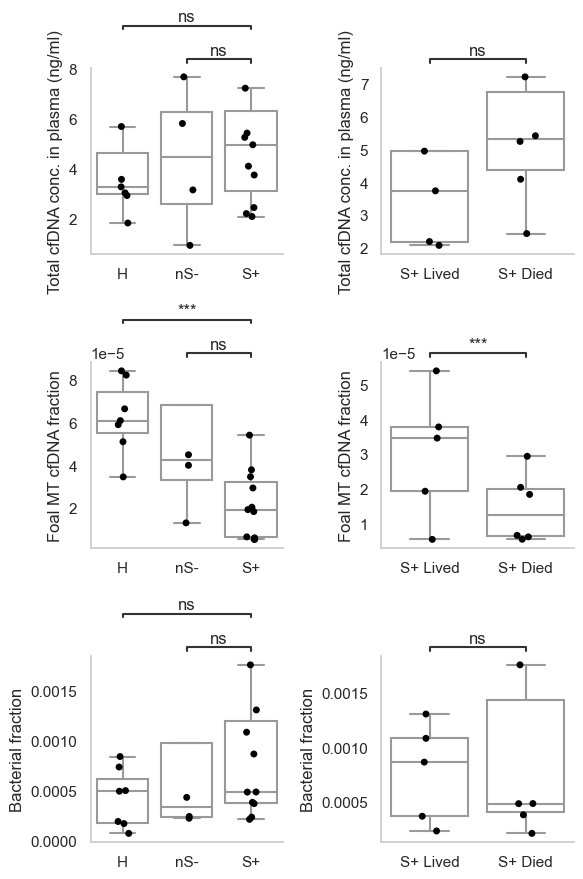

In [9]:
# Define your data
# 'Foal MT cfDNA conc. in plasma (ng/ml)',
analysis = ['Total cfDNA conc. in plasma (ng/ml)', 'Foal MT cfDNA fraction', 'Bacterial fraction', ]
categories = ['nSIRS_class', 'Lived']
# Ensure `df` and `septic_group` are defined earlier in your script.
base_on_df = [df, septic_group]

# Create subplots
# Create subplots
fig, axes = plt.subplots(len(analysis), len(categories), figsize=(len(categories) * 3, len(analysis) * 3))

# Loop over categories and features
for i, feature_y in enumerate(analysis):
    for j, (category_x, df_x) in enumerate(zip(categories, base_on_df)):
        if len(categories) > 1 or len(analysis) > 1:
            ax = axes[i][j]
        else:
            ax = axes
        # sns.boxplot(y = feature_y,  x = category_x[0] , data = category_x[1][:33], fill=False, fliersize=0, color = 'black', ax = axes[i][j], 
        #             showfliers=False)#palette=['darkgrey','darkgrey','salmon',],)
            
        sns.boxplot(y=feature_y, x=category_x, data=df_x, ax=ax, color='white', showfliers=False)
        ylims = ax.get_ylim()
        sns.stripplot(y=feature_y, x=category_x, data=df_x, color='black', ax=ax, jitter=True)
        ax.set(ylim=ylims)
        ax.spines[['right', 'top']].set_visible(False)
        ax.set_xlabel('')

        # Using a package...
        pairs = []
        for k in range(len(df[category_x].cat.categories)):
            for m in range(k+1, len(df[category_x].cat.categories)):
                pairs.append((df[category_x].cat.categories[k],df[category_x].cat.categories[m]))
        if ('H', 'nS-') in pairs:
            pairs.remove(('H', 'nS-'))

        annotator = Annotator(ax, pairs, data=df, x=category_x, y=feature_y, order=df[category_x].cat.categories) # hide_non_significant=True 
        annotator.configure(test='Mann-Whitney', text_format='star', loc='outside', verbose = 0)
        annotator.apply_and_annotate()

        # # Perform Mann-Whitney U test and annotate
        # group1 = df_x.loc[df_x[category_x] == df_x[category_x].unique()[0], feature_y]
        # group2 = df_x.loc[df_x[category_x] == df_x[category_x].unique()[1], feature_y]
        # groups = [group1, group2]
        # plot_u_test(groups, ax)
        
plt.tight_layout()
plt.savefig("../../output/03_microbial/figures/Fig102_exclude_outlier.pdf")
plt.savefig("../../output/03_microbial/figures/Fig102_exclude_outlier.pdf.png")

plt.show()

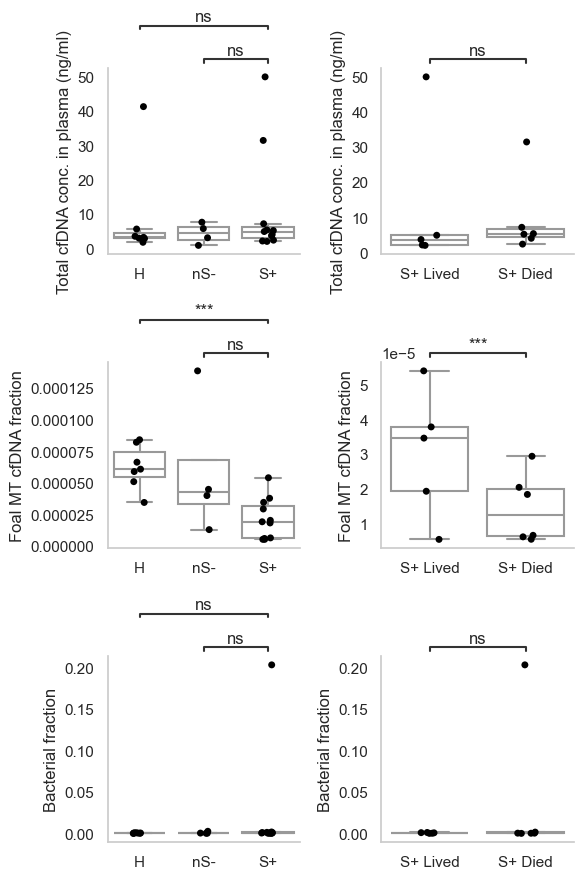

In [10]:
# Define your data
# 'Foal MT load in cfDNA (ng/ml)', 
analysis = ['Total cfDNA conc. in plasma (ng/ml)', 'Foal MT cfDNA fraction', 'Bacterial fraction', ]
categories = ['nSIRS_class', 'Lived']
# Ensure `df` and `septic_group` are defined earlier in your script.
base_on_df = [df, septic_group]

# Create subplots
fig, axes = plt.subplots(len(analysis), len(categories), figsize=(len(categories) * 3, len(analysis) * 3))

# Loop over categories and features
for i, feature_y in enumerate(analysis):
    for j, (category_x, df_x) in enumerate(zip(categories, base_on_df)):
        if len(categories) > 1 or len(analysis) > 1:
            ax = axes[i][j]
        else:
            ax = axes
        # sns.boxplot(y = feature_y,  x = category_x[0] , data = category_x[1][:33], fill=False, fliersize=0, color = 'black', ax = axes[i][j], 
        #             showfliers=False)#palette=['darkgrey','darkgrey','salmon',],)
            
        sns.boxplot(y=feature_y, x=category_x, data=df_x, ax=ax, color='white', showfliers=False)
############ Remove THIS TWO LINES to include showing outliners
#        ylims = ax.get_ylim()

        sns.stripplot(y=feature_y, x=category_x, data=df_x, color='black', ax=ax, jitter=True, )
#        ax.set(ylim=ylims)
        ax.spines[['right', 'top']].set_visible(False)
        ax.set_xlabel('')

        # TODO: remove testing H and nS-
        # Using a package...
        pairs = []
        for k in range(len(df[category_x].cat.categories)):
            for m in range(k+1, len(df[category_x].cat.categories)):
                pairs.append((df[category_x].cat.categories[k],df[category_x].cat.categories[m]))
        if ('H', 'nS-') in pairs:
            pairs.remove(('H', 'nS-'))
        annotator = Annotator(ax, pairs, data=df, x=category_x, y=feature_y, order=df[category_x].cat.categories) # hide_non_significant=True 
        annotator.configure(test='Mann-Whitney', text_format='star', loc='outside', verbose = 0)
        annotator.apply_and_annotate()

        # # Perform Mann-Whitney U test and annotate
        # group1 = df_x.loc[df_x[category_x] == df_x[category_x].unique()[0], feature_y]
        # group2 = df_x.loc[df_x[category_x] == df_x[category_x].unique()[1], feature_y]
        # groups = [group1, group2]
        # plot_u_test(groups, ax)
        
plt.tight_layout()
plt.savefig("../../output/03_microbial/figures/Fig102_include_outlier.pdf")
plt.savefig("../../output/03_microbial/figures/Fig102_include_outlier.png")

plt.show()


# Testing batch effects

In [11]:


order_prep_n = ['Srsly prep 1', 'Srsly prep 2', 'Srsly prep 3']
order_strip_n = ['Strip 1', 'Strip 2', 'Strip 3', 'Strip 4', 'Strip 5', ]
df['prep_n'] = pd.Categorical(df['prep_n'], categories=order_prep_n, ordered=True)
df['strip_n'] = pd.Categorical(df['strip_n'], categories=order_strip_n, ordered=True, )
df['isolation_batch'] = df['isolation_batch'].fillna(0).astype('int32')
df['isolation_batch'] = pd.Categorical( df['isolation_batch'], categories=[1, 2, 3, 4, 5, 6], ordered=True, ) 
df['isolation_by'] =pd.Categorical( df['isolation_by'], categories=['E','N'], ordered=True, ) 

df.rename(mapper = {'DNA concentration (elution total volume = 28ul-N, 35ul-E)':'DNA conc. (ng/ul)'},axis = 1,inplace=True, )
categories = [ 'prep_n',
            'strip_n',
            'isolation_batch',
            'isolation_by']
analysis = ['Total cfDNA conc. in plasma (ng/ml)', 
            'Foal MT cfDNA fraction', 
            'Bacterial fraction', ]



analysis Total cfDNA conc. in plasma (ng/ml)
category_x prep_n
category_x strip_n
category_x isolation_batch
category_x isolation_by
analysis Foal MT cfDNA fraction
category_x prep_n
category_x strip_n
category_x isolation_batch
category_x isolation_by
analysis Bacterial fraction
category_x prep_n
category_x strip_n
category_x isolation_batch
category_x isolation_by


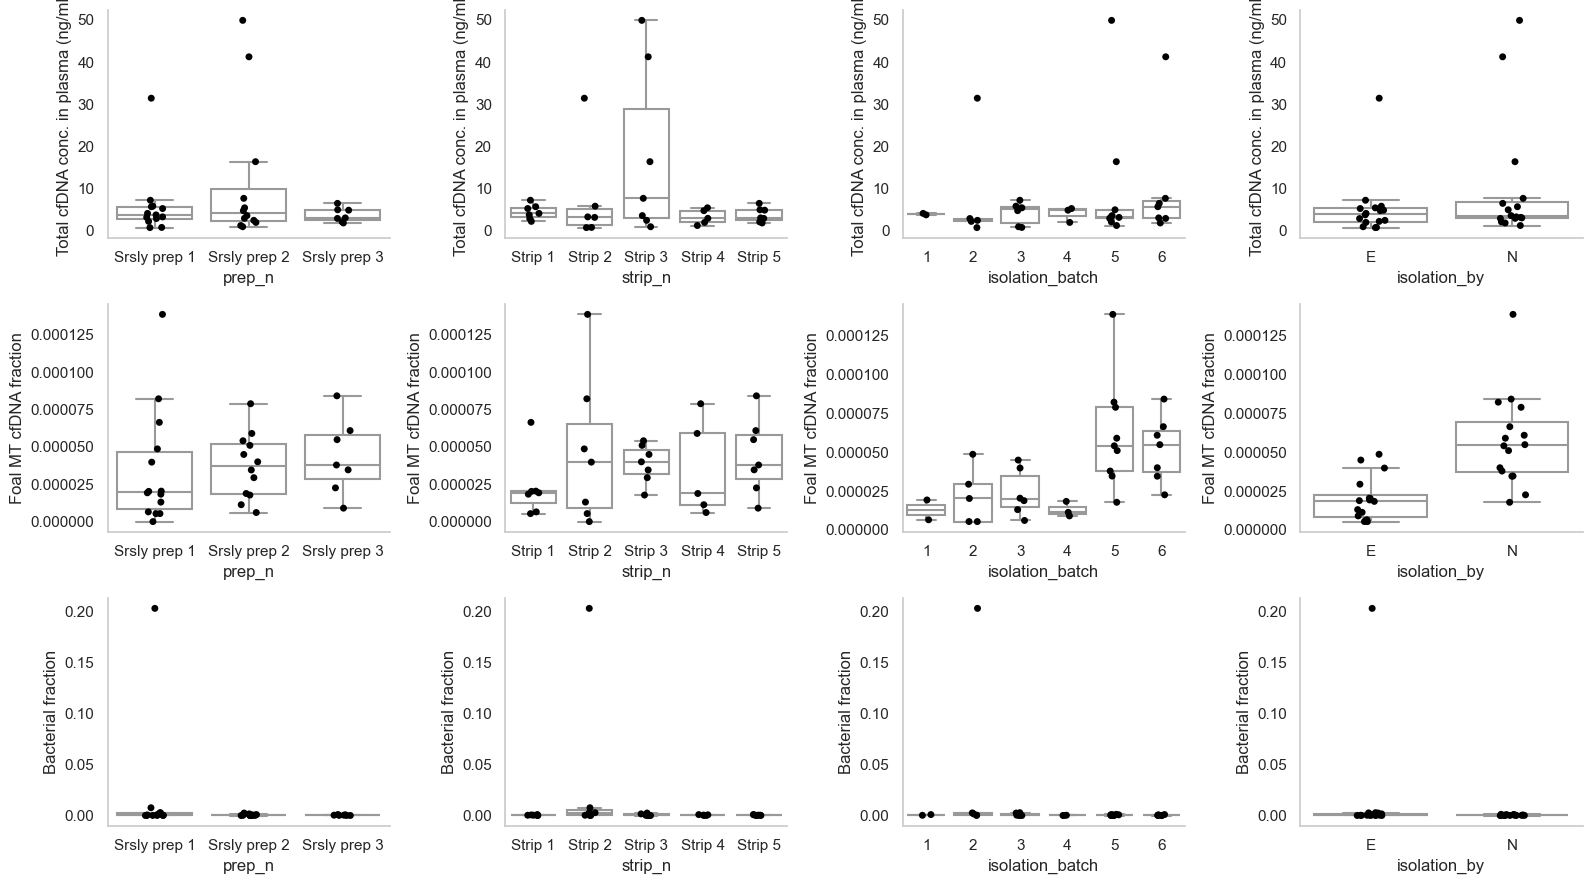

In [20]:
fig, axes = plt.subplots(len(analysis), len(categories), figsize=(len(categories) * 4, len(analysis) * 3))

# Loop over categories and features
for i, feature_y in enumerate(analysis):
    for j, (category_x, df_x) in enumerate(zip(categories, df)):
        sns.boxplot(y = feature_y,  x = category_x , data = df[:TOTAL_NUMBER_OF_FOAL_SAMPLES_plus1], fliersize=0, color = 'white', ax = axes[i][j], 
                    showfliers=False)#palette=['darkgrey','darkgrey','salmon',],)
#        ylims=axes[i][j].get_ylim()
        sns.stripplot(y = feature_y,  x = category_x , data = df[:TOTAL_NUMBER_OF_FOAL_SAMPLES_plus1], color = 'black',  ax = axes[i][j])
#        axes[i][j].set(ylim=ylims)
        axes[i][j].spines[['right', 'top']].set_visible(False)
        # axes[i][j].set_xticklabels(rotation=90)

        
        # Using a package to perform statistical test...
        pairs = []
        for k in range(len(df[category_x].cat.categories)):
            for m in range(k+1, len(df[category_x].cat.categories)):
                pairs.append((df[category_x].cat.categories[k],df[category_x].cat.categories[m]))
        if ('H', 'nS-') in pairs:
            pairs.remove(('H', 'nS-'))
        annotator = Annotator(ax, pairs, data=df, x=category_x, y=feature_y, order=df[category_x].cat.categories, ) 
        annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose = 0 )
        annotator.apply_and_annotate()

plt.tight_layout()
plt.savefig("../../output/03_microbial/figures/SupplFig203_batch_effect_include_outlier.pdf")
plt.savefig("../../output/03_microbial/figures/SupplFig203_batch_effect_include_outlier.pdf.png")

plt.show()


/Users/lchen/mambaforge-darwin-x86/envs/py310/lib/python3.10/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/lchen/mambaforge-darwin-x86/envs/py310/lib/python3.10/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/lchen/mambaforge-darwin-x86/envs/py310/lib/python3.10/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/lchen/mambaforge-darwin-x86/envs/py310/lib/python3.10/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations ca

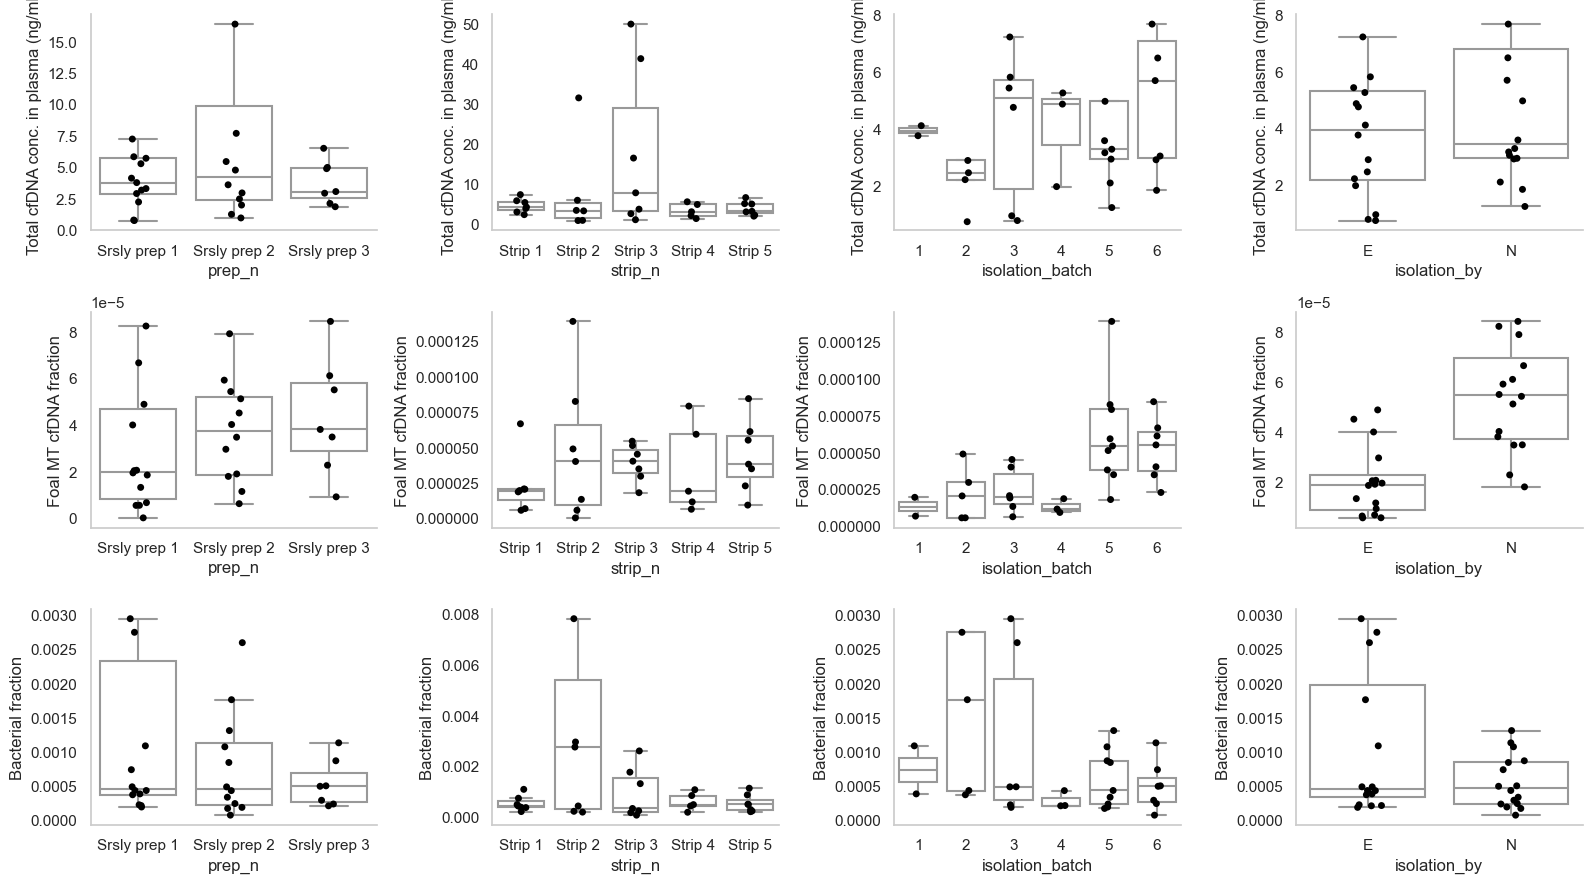

In [25]:
# Exclude outlier
fig, axes = plt.subplots(len(analysis), len(categories), figsize=(len(categories) * 4, len(analysis) * 3))

# Loop over categories and features
for i, feature_y in enumerate(analysis):
    for j, (category_x, df_x) in enumerate(zip(categories, df)):
        sns.boxplot(y = feature_y,  x = category_x , data = df[:TOTAL_NUMBER_OF_FOAL_SAMPLES_plus1], fliersize=0, color = 'white', ax = axes[i][j], 
                    showfliers=False)#palette=['darkgrey','darkgrey','salmon',],)
        ylims=axes[i][j].get_ylim()
        sns.stripplot(y = feature_y,  x = category_x , data = df[:TOTAL_NUMBER_OF_FOAL_SAMPLES_plus1], color = 'black',  ax = axes[i][j])
        axes[i][j].spines[['right', 'top']].set_visible(False)
        # axes[i][j].set_xticklabels(rotation=90)

        axes[i][j].set(ylim=ylims)
         
        # Using a package to perform statistical test...
        pairs = []
        for k in range(len(df[category_x].cat.categories)):
            for m in range(k+1, len(df[category_x].cat.categories)):
                pairs.append((df[category_x].cat.categories[k],df[category_x].cat.categories[m]))
        if ('H', 'nS-') in pairs:
            pairs.remove(('H', 'nS-'))
        annotator = Annotator(ax, pairs, data=df, x=category_x, y=feature_y, order=df[category_x].cat.categories, ) 
        annotator.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose = 0 )
        annotator.apply_and_annotate()

plt.tight_layout()
plt.savefig("../../output/03_microbial/figures/SupplFig203_batch_effect_exclude_outlier.pdf")
plt.savefig("../../output/03_microbial/figures/SupplFig203_batch_effect_exclude_outlier.pdf.png")

plt.show()
